In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
import random
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/expedia
!ls

/content/drive/My Drive/expedia
destinations.csv		   proc_train.csv	  test.csv
expedia-hotel-recommendations.zip  sample_submission.csv  train.csv


In [4]:
df_train = []
i = 1
for chunk in pd.read_csv('train.csv', chunksize=10**6):
  df_train.append(chunk.loc[chunk['is_booking'] == 1])
  print(i,end=' ')
  i += 1
df_train = pd.concat(df_train)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

In [5]:
df_train.shape

(3000693, 24)

In [0]:
df_test = pd.read_csv('test.csv')
df_des = pd.read_csv('destinations.csv')
df_sub = pd.read_csv('sample_submission.csv')

In [7]:
df_train.tail()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
37670275,2013-10-22 22:07:42,2,3,66,174,26232,113.0804,1198182,0,0,0,2013-10-23,2013-10-24,1,0,1,24144,6,1,1,2,50,967,7
37670277,2013-10-30 15:34:11,2,3,66,174,24103,254.2758,1198182,0,0,9,2013-10-30,2013-10-31,1,0,1,24144,6,1,1,2,50,967,42
37670281,2014-01-27 15:02:51,2,3,66,174,26232,535.0339,1198182,0,1,0,2014-02-23,2014-02-27,1,0,1,8273,1,1,1,2,50,660,68
37670285,2014-07-15 10:37:42,2,3,66,174,26232,649.6568,1198182,0,0,0,2014-07-27,2014-07-28,1,0,1,18811,1,1,1,2,50,592,77
37670292,2014-09-18 08:52:42,2,3,66,462,12565,106.4274,1198182,0,0,0,2014-09-18,2014-09-19,1,0,1,18811,1,1,1,2,50,592,42


In [8]:
df_sub.tail()

,id,hotel_cluster
2528238,2528238,99 1
2528239,2528239,99 1
2528240,2528240,99 1
2528241,2528241,99 1
2528242,2528242,99 1


In [9]:
df_train.isnull().sum()

date_time                          0
site_name                          0
posa_continent                     0
user_location_country              0
user_location_region               0
user_location_city                 0
orig_destination_distance    1015179
user_id                            0
is_mobile                          0
is_package                         0
channel                            0
srch_ci                            0
srch_co                            0
srch_adults_cnt                    0
srch_children_cnt                  0
srch_rm_cnt                        0
srch_destination_id                0
srch_destination_type_id           0
is_booking                         0
cnt                                0
hotel_continent                    0
hotel_country                      0
hotel_market                       0
hotel_cluster                      0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd55716fd68>]],
      dtype=object)

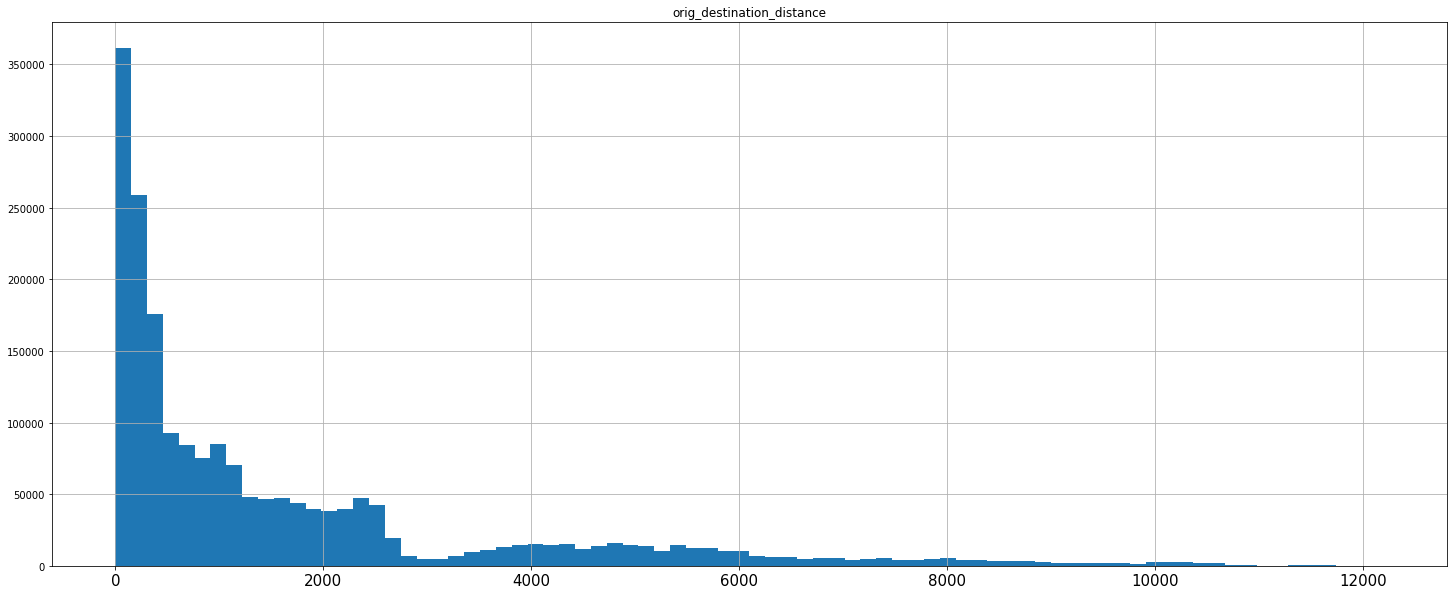

In [10]:
pd.DataFrame.hist(df_train,'orig_destination_distance',bins=80,figsize=(25,10),xlabelsize=15)

In [11]:
mean_orig = df_train['orig_destination_distance'].mean()
print(mean_orig)

1688.6816435864548


In [12]:
med_orig = df_train['orig_destination_distance'].median()
print(med_orig)

805.78415


In [0]:
df_train['orig_destination_distance'].fillna(med_orig, inplace = True)

In [0]:
def process(df):
  df['srch_ci'] = pd.to_datetime(df['srch_ci'])
  df['srch_co'] = pd.to_datetime(df['srch_co'])
  df['date_time'] = pd.to_datetime(df['date_time'])
    
  df['stay_dur'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')
  df['no_of_days_bef_booking'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[D]')

  df['Cin_day'] = df["srch_ci"].apply(lambda x: x.day)
  df['Cin_month'] = df["srch_ci"].apply(lambda x: x.month)
  df['Cin_year'] = df["srch_ci"].apply(lambda x: x.year)

  df['Co_day'] = df["srch_co"].apply(lambda x: x.day)
  df['Co_month'] = df["srch_co"].apply(lambda x: x.month)
  df['Co_year'] = df["srch_co"].apply(lambda x: x.year)

  return df

In [0]:
def chunker(seq, size):
  return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [16]:
count = 1
cdf = []
for chunk_df in chunker(df_train,50000):
    chunk_result = process(chunk_df)
    cdf.append(chunk_result)
    print(count,end=' ')
    count += 1

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 

In [0]:
tr_df = pd.concat(cdf)

In [18]:
l = list(tr_df.columns)
for i in l:
  print('\'' + str(i) + '\'', end=', ')

'date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster', 'stay_dur', 'no_of_days_bef_booking', 'Cin_day', 'Cin_month', 'Cin_year', 'Co_day', 'Co_month', 'Co_year', 

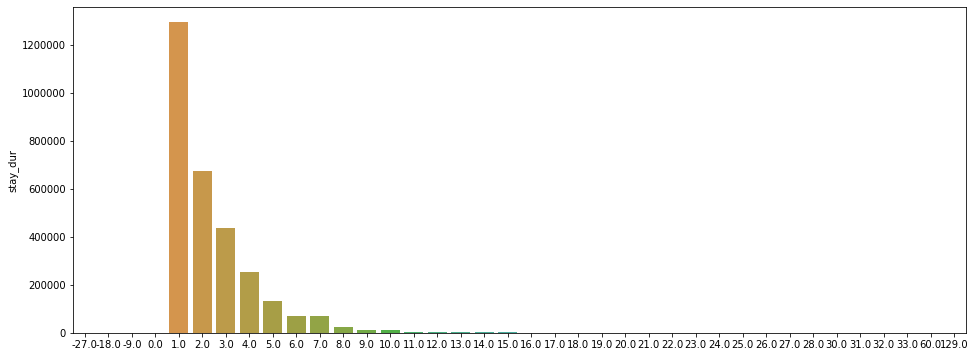

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.barplot(x=tr_df.stay_dur.value_counts().index, y=tr_df.stay_dur.value_counts(), ax=ax)

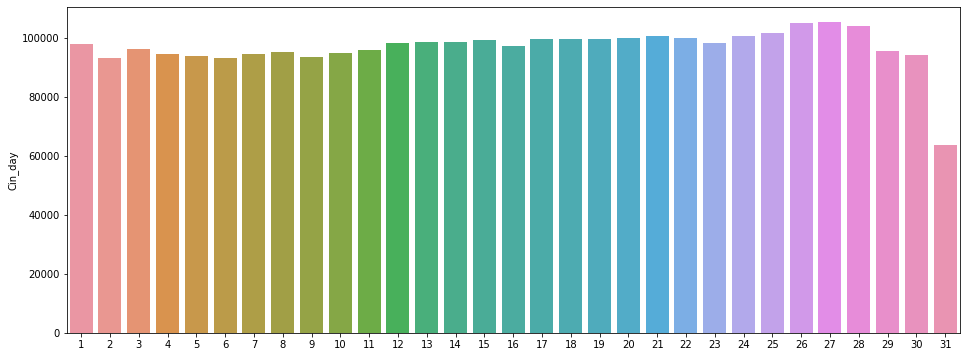

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.barplot(x=tr_df.Cin_day.value_counts().index, y=tr_df.Cin_day.value_counts(),ax=ax)

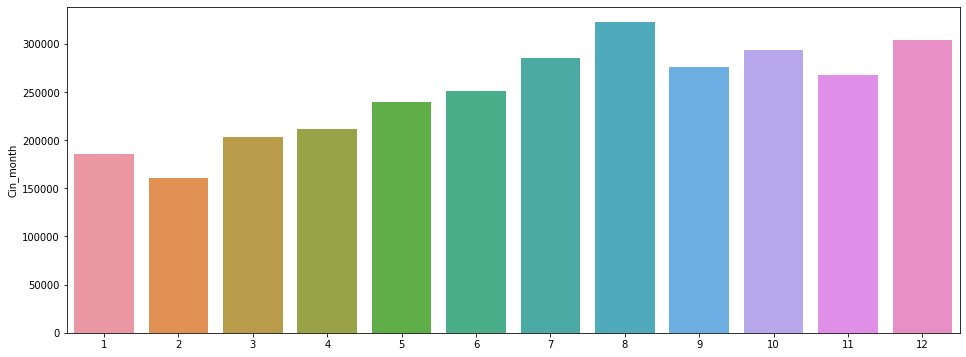

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.barplot(x=tr_df.Cin_month.value_counts().index, y=tr_df.Cin_month.value_counts(),ax=ax) 

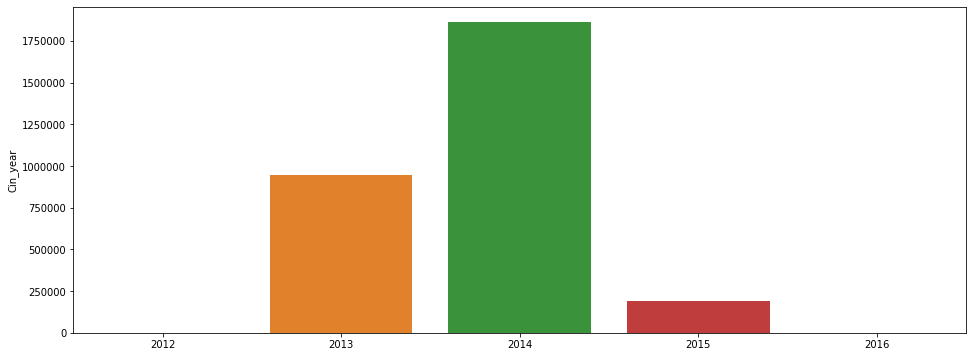

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.barplot(x=tr_df.Cin_year.value_counts().index, y=tr_df.Cin_year.value_counts(),ax=ax) 

In [23]:
tr_df.shape

(3000693, 32)

In [0]:
to_drop = ['date_time', 'site_name', 'user_id','srch_ci', 'srch_co', 'srch_destination_id', 'is_booking', 'cnt', 'hotel_cluster']

In [0]:
X = tr_df.drop(to_drop, axis=1)
y = tr_df.hotel_cluster

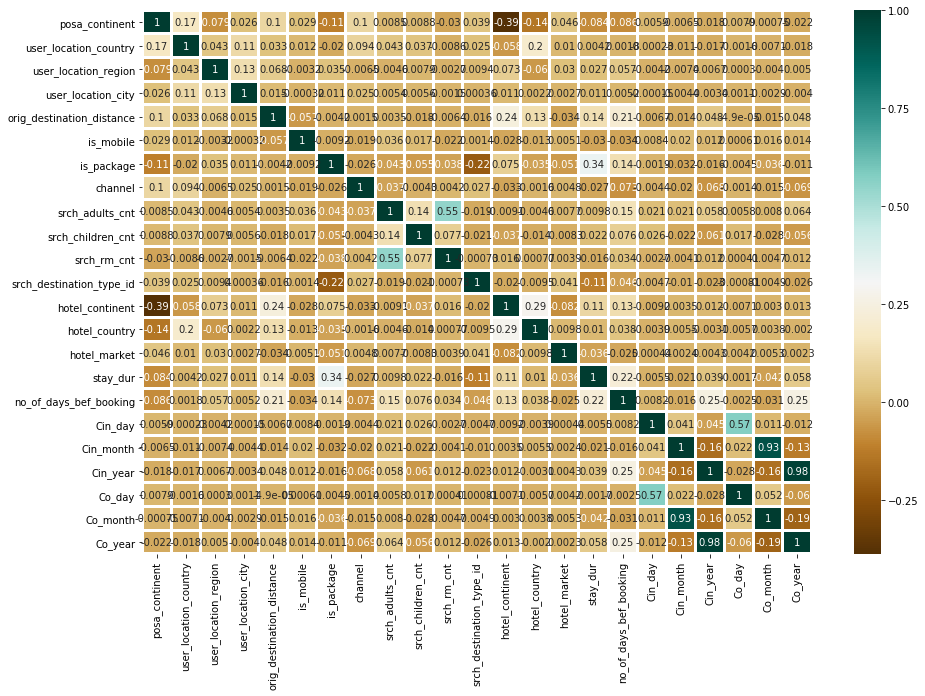

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(X.corr(),cmap='BrBG',ax=ax,annot=True,linewidths=2)

In [27]:
X.shape

(3000693, 23)

In [0]:
to_drop_2 = ['Co_month', 'Co_year', 'Co_day','srch_rm_cnt', 'hotel_continent', 'posa_continent']
X = X.drop(to_drop_2, axis=1)

In [29]:
print(X.shape)
y.shape

(3000693, 17)


(3000693,)

In [0]:
X = X.to_numpy()
y = y.to_numpy()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=0, stratify=y)

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2550589, 17)
(2550589,)
(450104, 17)
(450104,)


In [33]:
#Using Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [34]:
y_pred_gnb = gnb.predict(X_test)
accuracy = accuracy_score(y_test,y_pred_gnb)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 5.7353411656%


In [35]:
#Using KNN classifier
classifier = knc(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [36]:
y_pred_knn = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred_knn)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 10.7668449958%


In [0]:
def chunk(a,n):
  for i in range((a.shape[0] // n )):
    yield a[n*i:min(a.shape[0],n*(i+1))]

def chunk_v2(a,n):
  for i in range((a.shape[0] // n )+1):
    yield a[n*i:min(a.shape[0],n*(i+1))]

In [0]:
#Using RandomForest Classifier
model_rf = RandomForestClassifier(n_estimators=7,max_depth=50 ,random_state=0, warm_start=True)

In [39]:
xt = chunk(X_train,40000)
yt = chunk(y_train,40000)
type(xt)

generator

In [40]:
#Fitting training data into the model in batches
count = 0
for xtr, ytr in zip(xt, yt):
  model_rf.fit(xtr,ytr)
  model_rf.n_estimators += 7
  count += 1
  print(count,end=' ')
  if(count%20==0):
    print()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
61 62 63 

In [41]:
y_pred_rf = model_rf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred_rf)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 10.9836837709%


In [42]:
xt = chunk(X_train,50000)
yt = chunk(y_train,50000)
type(xt)

generator

In [0]:
#Using XGBoost
model_xgb = XGBClassifier(n_estimators=40, max_depth=6 ,objective='multi:softprob')

In [44]:
model_xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='mlogloss', eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:4.39538
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:4.27804
[2]	validation_0-mlogloss:4.1894
[3]	validation_0-mlogloss:4.11446
[4]	validation_0-mlogloss:4.05048
[5]	validation_0-mlogloss:3.9957
[6]	validation_0-mlogloss:3.94747
[7]	validation_0-mlogloss:3.90483
[8]	validation_0-mlogloss:3.86569
[9]	validation_0-mlogloss:3.83077
[10]	validation_0-mlogloss:3.79904
[11]	validation_0-mlogloss:3.77016
[12]	validation_0-mlogloss:3.74336
[13]	validation_0-mlogloss:3.7189
[14]	validation_0-mlogloss:3.69567
[15]	validation_0-mlogloss:3.67413
[16]	validation_0-mlogloss:3.65394
[17]	validation_0-mlogloss:3.63588
[18]	validation_0-mlogloss:3.61877
[19]	validation_0-mlogloss:3.60285
[20]	validation_0-mlogloss:3.58762
[21]	validation_0-mlogloss:3.57332
[22]	validation_0-mlogloss:3.55987
[23]	validation_0-mlogloss:3.54744
[24]	validation_0-mlogloss:3.53513
[25]	validation_0-mlogloss:3.52418
[26]	validation_0-mlogloss:3.51366

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
y_pred_xgb = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test,y_pred_xgb)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

Accuracy: 15.2504754457%


In [46]:
"""count = 0
pr_model = None
for xtr, ytr in zip(xt, yt):
  pr_model = model_xgb.fit(xtr, ytr, xgb_model = pr_model).get_booster()
  count += 1
  print(count,end=' ')
  if(count%1==0):
    break  """

"""xt = chunk_v2(X_test,40000)
yt = chunk_v2(y_test,40000)
type(xt)"""

"""tc = []
d = 0
count = 0
for xtr, ytr in zip(xt, yt):
  y_pred_xgb = model_xgb.predict(xtr)
  accuracy = accuracy_score(ytr,y_pred_xgb)
  count += 1
  tc.append(accuracy*len(xtr))
  d += len(xtr)
  print("Accuracy B%d : %.10f%%" % (count, accuracy*100.0))
print('Total Accuracy : ' + str((sum(tc)/d)*100.0) + '%')"""

'tc = []\nd = 0\ncount = 0\nfor xtr, ytr in zip(xt, yt):\n  y_pred_xgb = model_xgb.predict(xtr)\n  accuracy = accuracy_score(ytr,y_pred_xgb)\n  count += 1\n  tc.append(accuracy*len(xtr))\n  d += len(xtr)\n  print("Accuracy B%d : %.10f%%" % (count, accuracy*100.0))\nprint(\'Total Accuracy : \' + str((sum(tc)/d)*100.0) + \'%\')'